# GHG Emission Regression

Target: 
> - `Total_GHG`

Features:
> - `Unit Type` (categorical - 9 subgroups)
> - `General Fuel Type` (categorical - 4 subgroups)
> - `Industry` (categorical - 9 subgroups)
> - `Unit Type` (numerical)
> - `Max Heat Capacity` (numerical)
> - `State%_Dem` (numerical)
> - `Revenue` (numerical)
> - `Operating Income` (numerical)
> - `Net Income` (numerical)
> - `Total Assets` (numerical)
> - `Total Equity` (numerical)
> - `# Employees` (numerical)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pickle

%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [2]:
GHG_df = pd.read_pickle('Pickle_files/final_GHG_dataset.pkl')
GHG_df.head()

,PARENT COMPANY NAME,Unit Type,General Fuel Type,Industry,Number_of_units,GHG_total,Max_Heat_Cap,State%_Dem,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,30452.736,32.0,-21.32,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
1,3M CO,Combustion,Natural Gas,Other,1.0,106258.176,223.0,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
2,3M CO,Combustion,Petroleum Products,Other,1.0,106258.176,223.0,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
3,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,29055.240,18.0,-14.92,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
4,3M CO,Combustion,Natural Gas,Other,1.0,45435.226,60.0,0.22,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0


#### Get rid of GHG totals that are 0 -> likely wrong

In [3]:
GHG_mask = GHG_df.GHG_total > 0.0
GHG_df = GHG_df[GHG_mask]
GHG_df.head()

,PARENT COMPANY NAME,Unit Type,General Fuel Type,Industry,Number_of_units,GHG_total,Max_Heat_Cap,State%_Dem,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,30452.736,32.0,-21.32,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
1,3M CO,Combustion,Natural Gas,Other,1.0,106258.176,223.0,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
2,3M CO,Combustion,Petroleum Products,Other,1.0,106258.176,223.0,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
3,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,29055.240,18.0,-14.92,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
4,3M CO,Combustion,Natural Gas,Other,1.0,45435.226,60.0,0.22,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0


#### Have to reset index to get proper matchup between X and y data frame and series (respectively)

In [4]:
GHG_df = GHG_df.reset_index().drop(columns = ['index'])
GHG_df

,PARENT COMPANY NAME,Unit Type,General Fuel Type,Industry,Number_of_units,GHG_total,Max_Heat_Cap,State%_Dem,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,30452.736,32.000,-21.32,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
1,3M CO,Combustion,Natural Gas,Other,1.0,106258.176,223.000,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
2,3M CO,Combustion,Petroleum Products,Other,1.0,106258.176,223.000,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
3,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,29055.240,18.000,-14.92,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
4,3M CO,Combustion,Natural Gas,Other,1.0,45435.226,60.000,0.22,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,CMS ENERGY CORP,Combustion,Natural Gas,Power Plants,3.0,307.400,18.035,5.13,6.680000e+09,2.514000e+09,7.520000e+08,1.038230e+11,2.077400e+10,8148.0
4363,CMS ENERGY CORP,Combustion,Petroleum Products,Power Plants,1.0,5.400,0.100,5.13,6.680000e+09,2.514000e+09,7.520000e+08,1.038230e+11,2.077400e+10,8148.0
4364,MIDCOAST ENERGY LLC,Combustion,Natural Gas,Petroleum and Natural Gas Systems,1.0,14182.096,8.500,-21.32,2.720000e+10,1.838000e+09,1.368000e+09,8.006400e+10,2.904000e+10,11012.0
4365,VOLT PARENT LP,Natural Gas Line,Natural Gas,Power Plants,1.0,689.348,5.700,12.01,1.152620e+10,2.514000e+09,1.376000e+09,1.038230e+11,2.077400e+10,11075.0


In [5]:
GHG_numeric = GHG_df[['GHG_total','Number_of_units', 
                      'Max_Heat_Cap',
                      'State%_Dem','Revenue','Operating_income','Net_income','Total_assets',
                      'Total_equity','Employees']]

In [6]:
GHG_numeric.corr()

,GHG_total,Number_of_units,Max_Heat_Cap,State%_Dem,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
GHG_total,1.000000,0.230259,0.225595,-0.068208,0.131126,-0.081640,-0.003208,0.011221,0.015268,0.010480
Number_of_units,0.230259,1.000000,0.249368,-0.013592,0.071769,0.013630,0.041847,0.040984,0.040915,0.004176
Max_Heat_Cap,0.225595,0.249368,1.000000,-0.019441,0.081263,0.039631,0.055909,0.075662,0.072395,0.057666
State%_Dem,-0.068208,-0.013592,-0.019441,1.000000,-0.114731,0.024489,-0.027286,-0.069915,-0.082628,-0.037853
Revenue,0.131126,0.071769,0.081263,-0.114731,1.000000,0.335127,0.648458,0.772959,0.770909,0.729419
Operating_income,-0.081640,0.013630,0.039631,0.024489,0.335127,1.000000,0.636408,0.619997,0.634679,0.671939
Net_income,-0.003208,0.041847,0.055909,-0.027286,0.648458,0.636408,1.000000,0.807348,0.827056,0.732349
Total_assets,0.011221,0.040984,0.075662,-0.069915,0.772959,0.619997,0.807348,1.000000,0.988563,0.790883
Total_equity,0.015268,0.040915,0.072395,-0.082628,0.770909,0.634679,0.827056,0.988563,1.000000,0.812219
Employees,0.010480,0.004176,0.057666,-0.037853,0.729419,0.671939,0.732349,0.790883,0.812219,1.000000


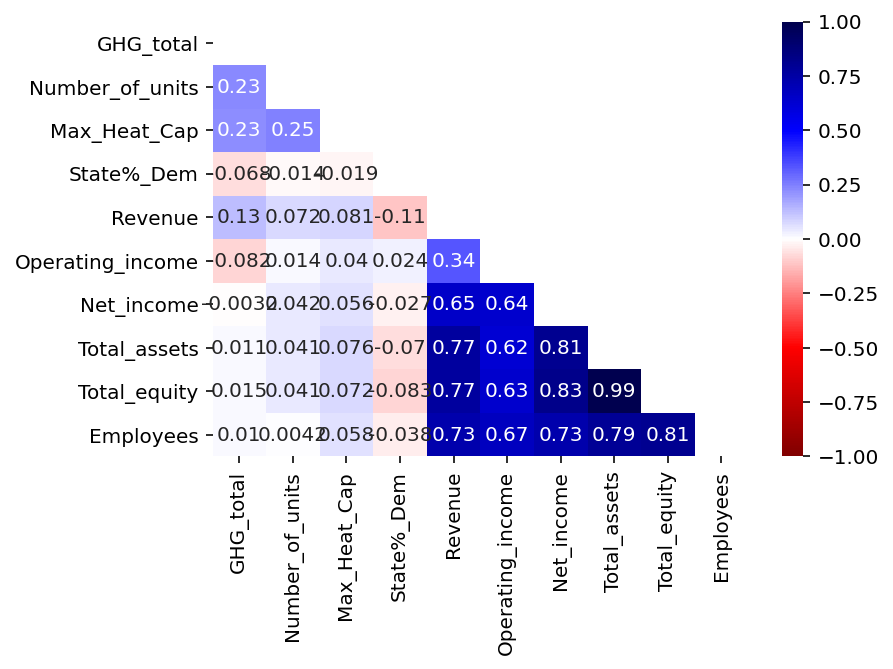

In [7]:
upper = np.triu(GHG_numeric.corr())
sns.heatmap(GHG_numeric.corr(), cmap = 'seismic_r',annot=True, vmin=-1, vmax=1, mask=upper);

In [8]:
GHG_numeric.describe()

,GHG_total,Number_of_units,Max_Heat_Cap,State%_Dem,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
count,4.367000e+03,4367.000000,4367.000000,4367.000000,4.367000e+03,4.367000e+03,4.367000e+03,4.367000e+03,4.367000e+03,4367.000000
mean,9.413149e+04,1.987635,248.800662,-7.395564,5.278767e+10,3.198653e+09,3.391161e+09,1.087998e+11,4.433383e+10,47753.154110
std,3.200122e+05,2.883814,1383.053551,14.366788,6.001647e+10,1.186207e+10,9.273213e+09,1.610833e+11,8.190694e+10,68471.610454
min,1.000000e-01,1.000000,0.000220,-40.490000,7.500000e+08,-2.945000e+10,-2.073202e+10,1.634000e+09,-6.450000e+08,624.000000
25%,4.433930e+02,1.000000,9.275000,-21.320000,1.373500e+10,1.838000e+09,4.820000e+08,3.171840e+10,1.078800e+10,11012.000000
50%,1.870350e+04,1.000000,60.260000,-7.680000,2.720000e+10,2.294000e+09,1.376000e+09,6.052202e+10,2.505700e+10,23350.000000
75%,5.882998e+04,2.000000,167.500000,2.400000,6.465600e+10,3.204000e+09,3.103000e+09,1.038230e+11,2.904000e+10,51100.000000
max,8.861311e+06,49.000000,81850.000000,76.200000,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.000000


In [9]:
GHG_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4367 entries, 0 to 4366
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GHG_total         4367 non-null   float64
 1   Number_of_units   4367 non-null   float64
 2   Max_Heat_Cap      4367 non-null   float64
 3   State%_Dem        4367 non-null   float64
 4   Revenue           4367 non-null   float64
 5   Operating_income  4367 non-null   float64
 6   Net_income        4367 non-null   float64
 7   Total_assets      4367 non-null   float64
 8   Total_equity      4367 non-null   float64
 9   Employees         4367 non-null   float64
dtypes: float64(10)
memory usage: 341.3 KB


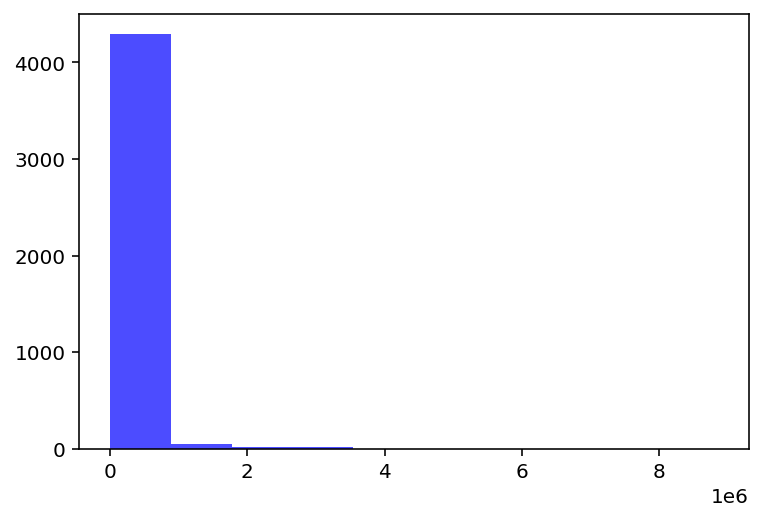

In [10]:
plt.hist(GHG_numeric.GHG_total, color = 'blue', alpha = 0.7);

## Modeling
### Get Baseline

In [11]:
y = GHG_numeric['GHG_total']
X_numeric = GHG_numeric[['Number_of_units', 'Max_Heat_Cap','State%_Dem',
                   'Revenue','Operating_income','Net_income','Total_assets','Total_equity','Employees']]
X_categorical = GHG_df[['Unit Type','General Fuel Type','Industry']]

### Numerical Data Only

In [12]:
model = LinearRegression()

model.fit(X_numeric, y)
score = model.score(X_numeric,y)

print('R\u00b2 for baseline numeric model = ', score)

R² for baseline numeric model =  0.12109286502047334


### Categorical Data Only

In [13]:
X_dummies = pd.get_dummies(X_categorical)

model = LinearRegression()

model.fit(X_dummies, y)
score = model.score(X_dummies,y)

print('R\u00b2 for baseline categorical model = ', score)

R² for baseline categorical model =  0.14139789581008488


#### *Interestingly, there is a slightly better initial $R^{2}$ for the categorical data on it's own.*
### Fit on all data

In [14]:
X_all = X_numeric.join(X_dummies)

model = LinearRegression()

model.fit(X_all, y)
score = model.score(X_all,y)

print('R\u00b2 for baseline model (all data) = ', score)

R² for baseline model (all data) =  0.20990895854143288


In [15]:
def diagnostic_plot(X, y):
    plt.figure(figsize=(20,8))
    
    rgr = LinearRegression()
    rgr.fit(X,y) # fitting linear regression
    pred = rgr.predict(X) # predicting y based on model fit
    res = y - pred
    
    plt.subplot(1,3,1)
    plt.hist(res, color = 'darkseagreen')
    plt.title('Residual distribution', fontsize = 15)
    plt.xticks(fontsize=12);
    
    plt.subplot(1, 3, 2)
    plt.scatter(pred, res)
    plt.title("Residual plot", fontsize = 15)
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", fontsize = 15)

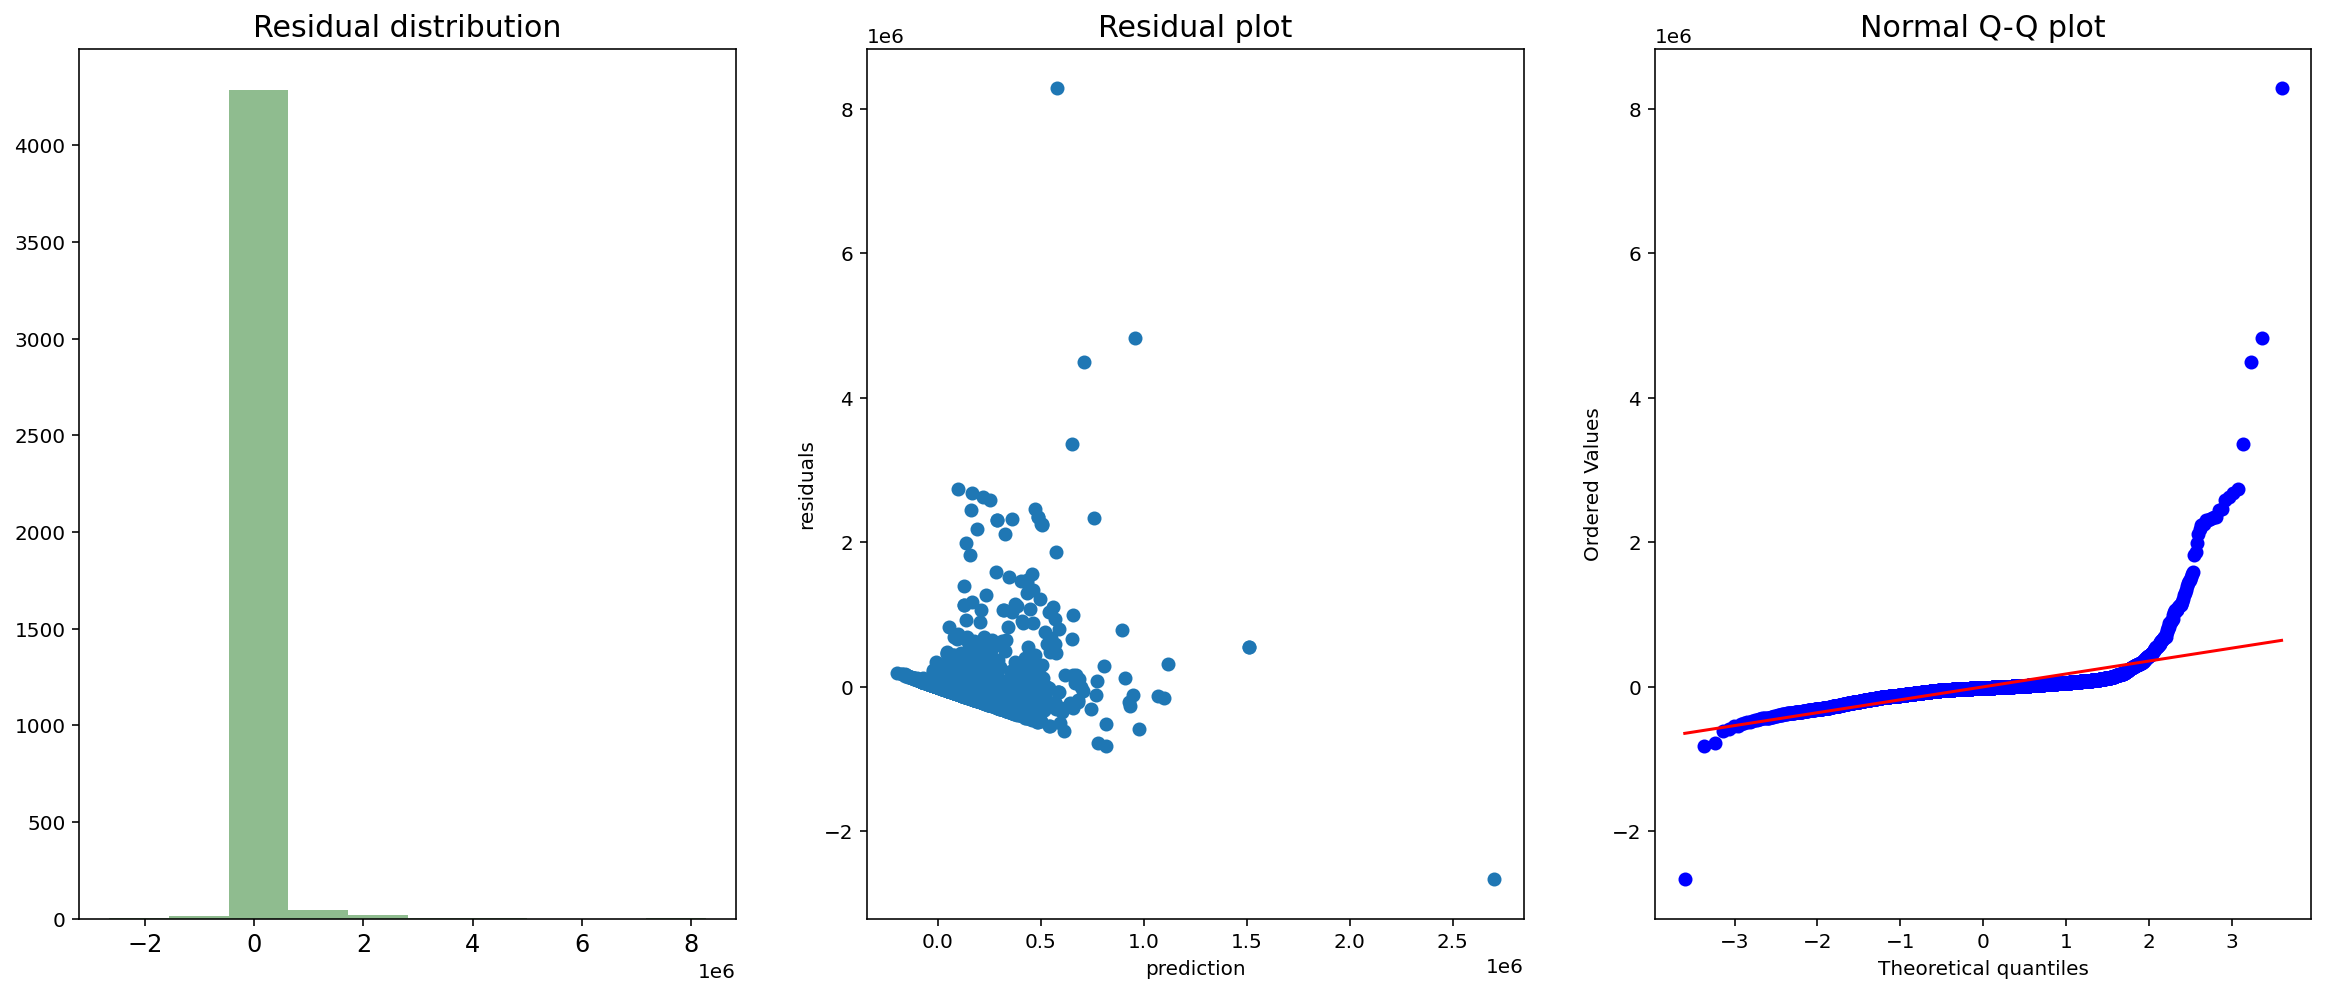

In [16]:
diagnostic_plot(X_all,y)

### Try Box-Cox Transformation on Target

Lambda: 0.12559676448383658


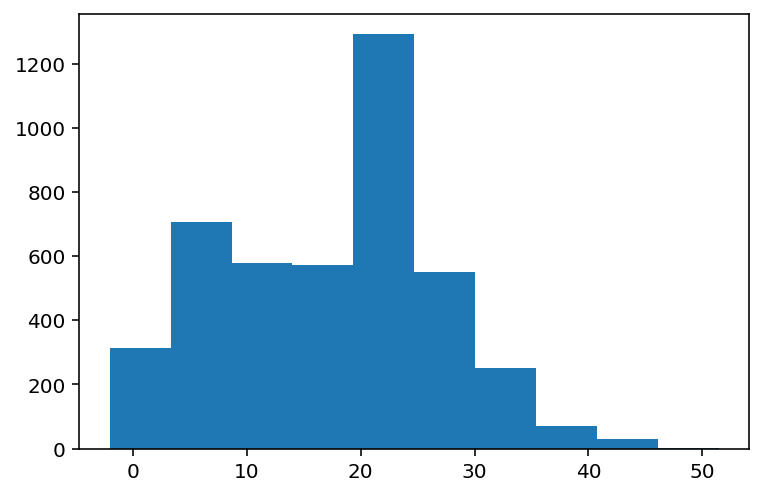

In [17]:
lamb=stats.boxcox_normmax(GHG_numeric.GHG_total, brack=(-3, 5)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_box_cox =(np.power(GHG_numeric.GHG_total,lamb)-1)/lamb #transform y based on box-cox

plt.hist(y_box_cox);

In [18]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_all, 
                                                          y_box_cox, 
                                                          test_size=0.1, 
                                                          random_state=42)

In [19]:
model = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=5)
scores = cross_val_score(model, X_train, y_train, cv=kfold)

print(scores)
print('Mean R\u00b2 for box-cox model (all data) = ', np.mean(scores))

model.fit(X_train, y_train)

[ 0.47259894 -1.42805041  0.48900703  0.48382876  0.45050269]
Mean R² for box-cox model (all data) =  0.09357740389488867


LinearRegression()

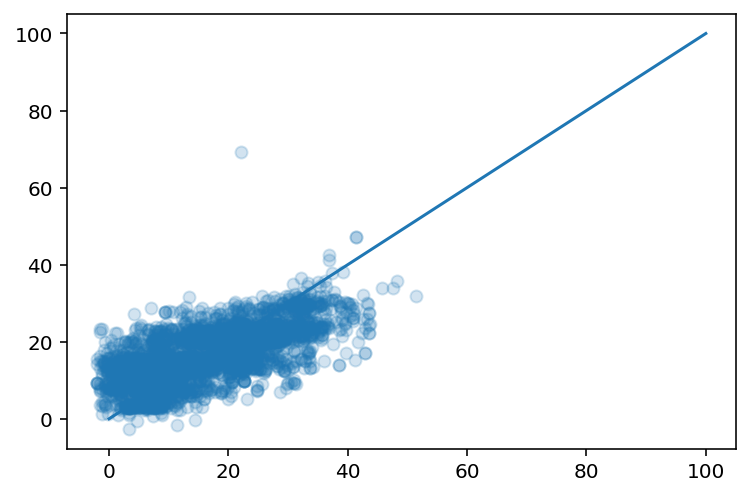

In [20]:
y_train_pred = model.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 100], [0, 100])

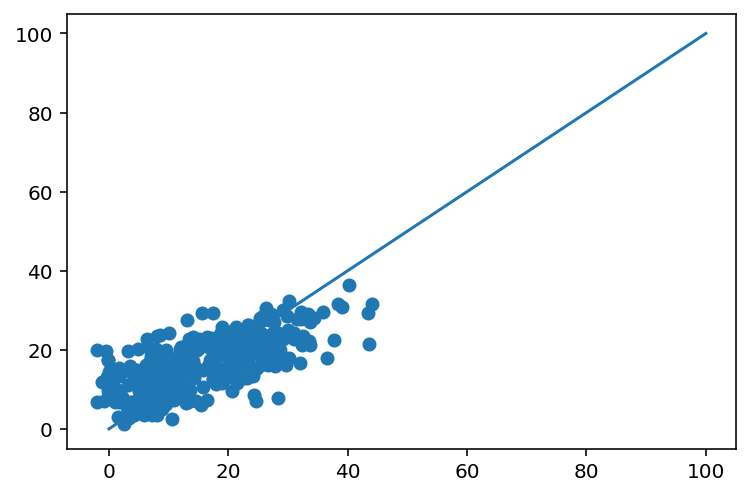

In [21]:
# Fitted vs. Actual on test
y_test_pred = model.predict(X_holdout)

plt.scatter(y_holdout, y_test_pred)
plt.plot([0, 100], [0, 100])

Text(0.5, 1.0, 'Residuals vs. Predictions')

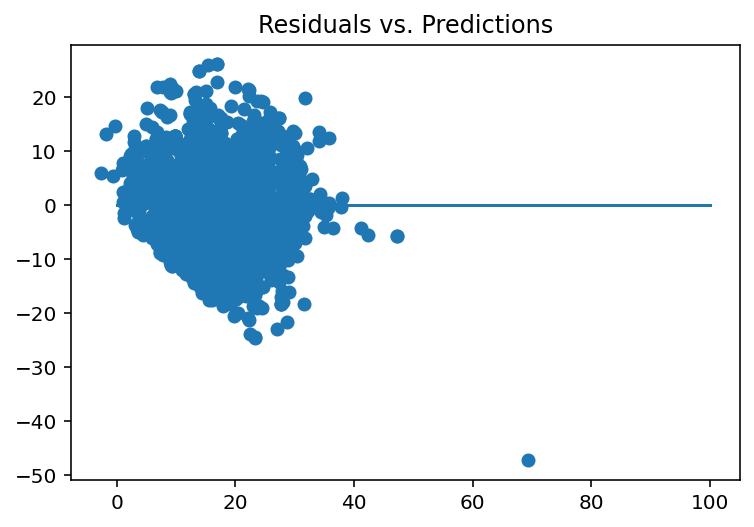

In [22]:
lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([0,100], [0, 0])
plt.title("Residuals vs. Predictions")

## Model testing

In [23]:
def lasso_score(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lasso = LassoCV(cv=5)
    scores = []
    
    for i in range(5):
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        scores.append(cross_val_score(lasso, X_scaled, y, cv=kf, scoring="r2"))
    
    return np.mean(scores)

### *Model test: y with boxcox, untransformed x*

In [24]:
lasso_score(X_train, y_train)

0.04070397381201845

In [25]:
lasso_score(X_holdout, y_holdout)

0.4382700998344585

In [26]:
def ridge_score(X, y):
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    alphas = 10**np.linspace(-1, 1, 100)
    ridge = RidgeCV(alphas=alphas, cv=5)
    scores = []
    
    for i in range(5):
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        scores.append(cross_val_score(ridge, X_scaled, y, cv=kf, scoring="r2"))
    
    return np.mean(scores)

In [27]:
ridge_score(X_train, y_train)

0.14767473762546215

In [28]:
ridge_score(X_holdout, y_holdout)

0.4494026255378198

In [29]:
def polynomial_reg_score(X, y):
    
    poly = PolynomialFeatures(interaction_only=True)
    X_poly = poly.fit_transform(X)
    lr_poly=LinearRegression()
    scores = []
    
    for i in range(5):
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        scores.append(cross_val_score(lr_poly, X_poly, y, cv=kf, scoring="r2"))
    
    return np.mean(scores)

In [30]:
polynomial_reg_score(X_train, y_train)

-0.24570238029413383

In [31]:
polynomial_reg_score(X_holdout, y_holdout)

-2.947116113651018

In [32]:
def linear_regression_score(X, y):
    
    lr = LinearRegression()
    scores = []
    
    for i in range(5):
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        scores.append(cross_val_score(lr, X, y, cv=kf, scoring="r2"))
    
    return np.mean(scores)

In [33]:
linear_regression_score(X_train, y_train)

0.13114450102234548

In [34]:
linear_regression_score(X_holdout, y_holdout)

0.4288433668289349

### Examine feature summary statistics - boxcox y with untransformed X

In [35]:
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              GHG_total   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     134.4
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:58:47   Log-Likelihood:                -13099.
No. Observations:                3930   AIC:                         2.625e+04
Df Residuals:                    3902   BIC:                         2.643e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         10.6497      0.343     31.012      0.000       9.976      11.323
Number_of_units                                0.4256      0.040     10.700      0.000       0.348       0.504
Max_Heat_Cap                                   0.0006   7.88e-05      7.754      0.000       0.000       0.001
State%_Dem                                    -0.0276      0.008     -3.504      0.000      -0.043      -0.012
Revenue                                     2.699e-11   4.43e-12      6.092      0.000    1.83e-11    3.57e-11
Operating_income                            1.224e-11   1.53e-11      0.800      0.424   -1.77e-11    4.22e-11
Net_income                                 -4.036e-11   2.28e-11     -1.774      0.076    -8.5e-11    4.25e-12
Total_assets                               -5.481e-12   5.45e-12     -1.006      0.314   -1.62e-11     5.2e-12
Total_equity                                3.549e-12   1.07e-11      0.331      0.741   -1.75e-11    2.46e-11
Employees                                  -1.817e-05   4.44e-06     -4.089      0.000   -2.69e-05   -9.46e-06
Unit Type_Boiler                               5.0239      0.445     11.286      0.000       4.151       5.897
Unit Type_Combustion                           5.4196      0.377     14.372      0.000       4.680       6.159
Unit Type_Furnace                              2.8089      0.900      3.121      0.002       1.044       4.573
Unit Type_Heater                              -0.7134      0.454     -1.571      0.116      -1.604       0.177
Unit Type_Heater adjacent                     -2.6178      1.031     -2.538      0.011      -4.640      -0.596
Unit Type_Natural Gas Line                    -4.3554      0.763     -5.712      0.000      -5.850      -2.860
Unit Type_Oxidizer                            -3.1759      0.899     -3.533      0.000      -4.938      -1.414
Unit Type_Pulverized Coal                      8.2599      1.891      4.367      0.000       4.552      11.968
General Fuel Type_Coal                         4.5841      1.235      3.712      0.000       2.163       7.005
General Fuel Type_Natural Gas                  2.7484      0.387      7.097      0.000       1.989       3.508
General Fuel Type_Other                        8.8622      0.478     18.540      0.000       7.925       9.799
General Fuel Type_Petroleum Products          -5.5449      0.412    -13.472      0.000      -6.352      -4.738
Industry_CO2                                   2.8540      0.918      3.110      0.002       1.055       4.653
Industry_Chemicals                             2.2283      0.500      4.456      0.000       1.248       3.209
Industry_Metals/Minerals                       3.4944      0.449      7.790      0.000

### Try droppping columns with regular y

In [36]:
X_all_dropped = X_all.drop(columns = ['Operating_income','Total_equity','Net_income'])

In [37]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_all_dropped, 
                                                          y, 
                                                          test_size=0.1, 
                                                          random_state=42)

In [38]:
model = LinearRegression()

model.fit(X_train, y_train)
score = model.score(X_train, y_train)

print('R\u00b2 for y with dropped features = ', score)

R² for y with dropped features =  0.20372048528857478


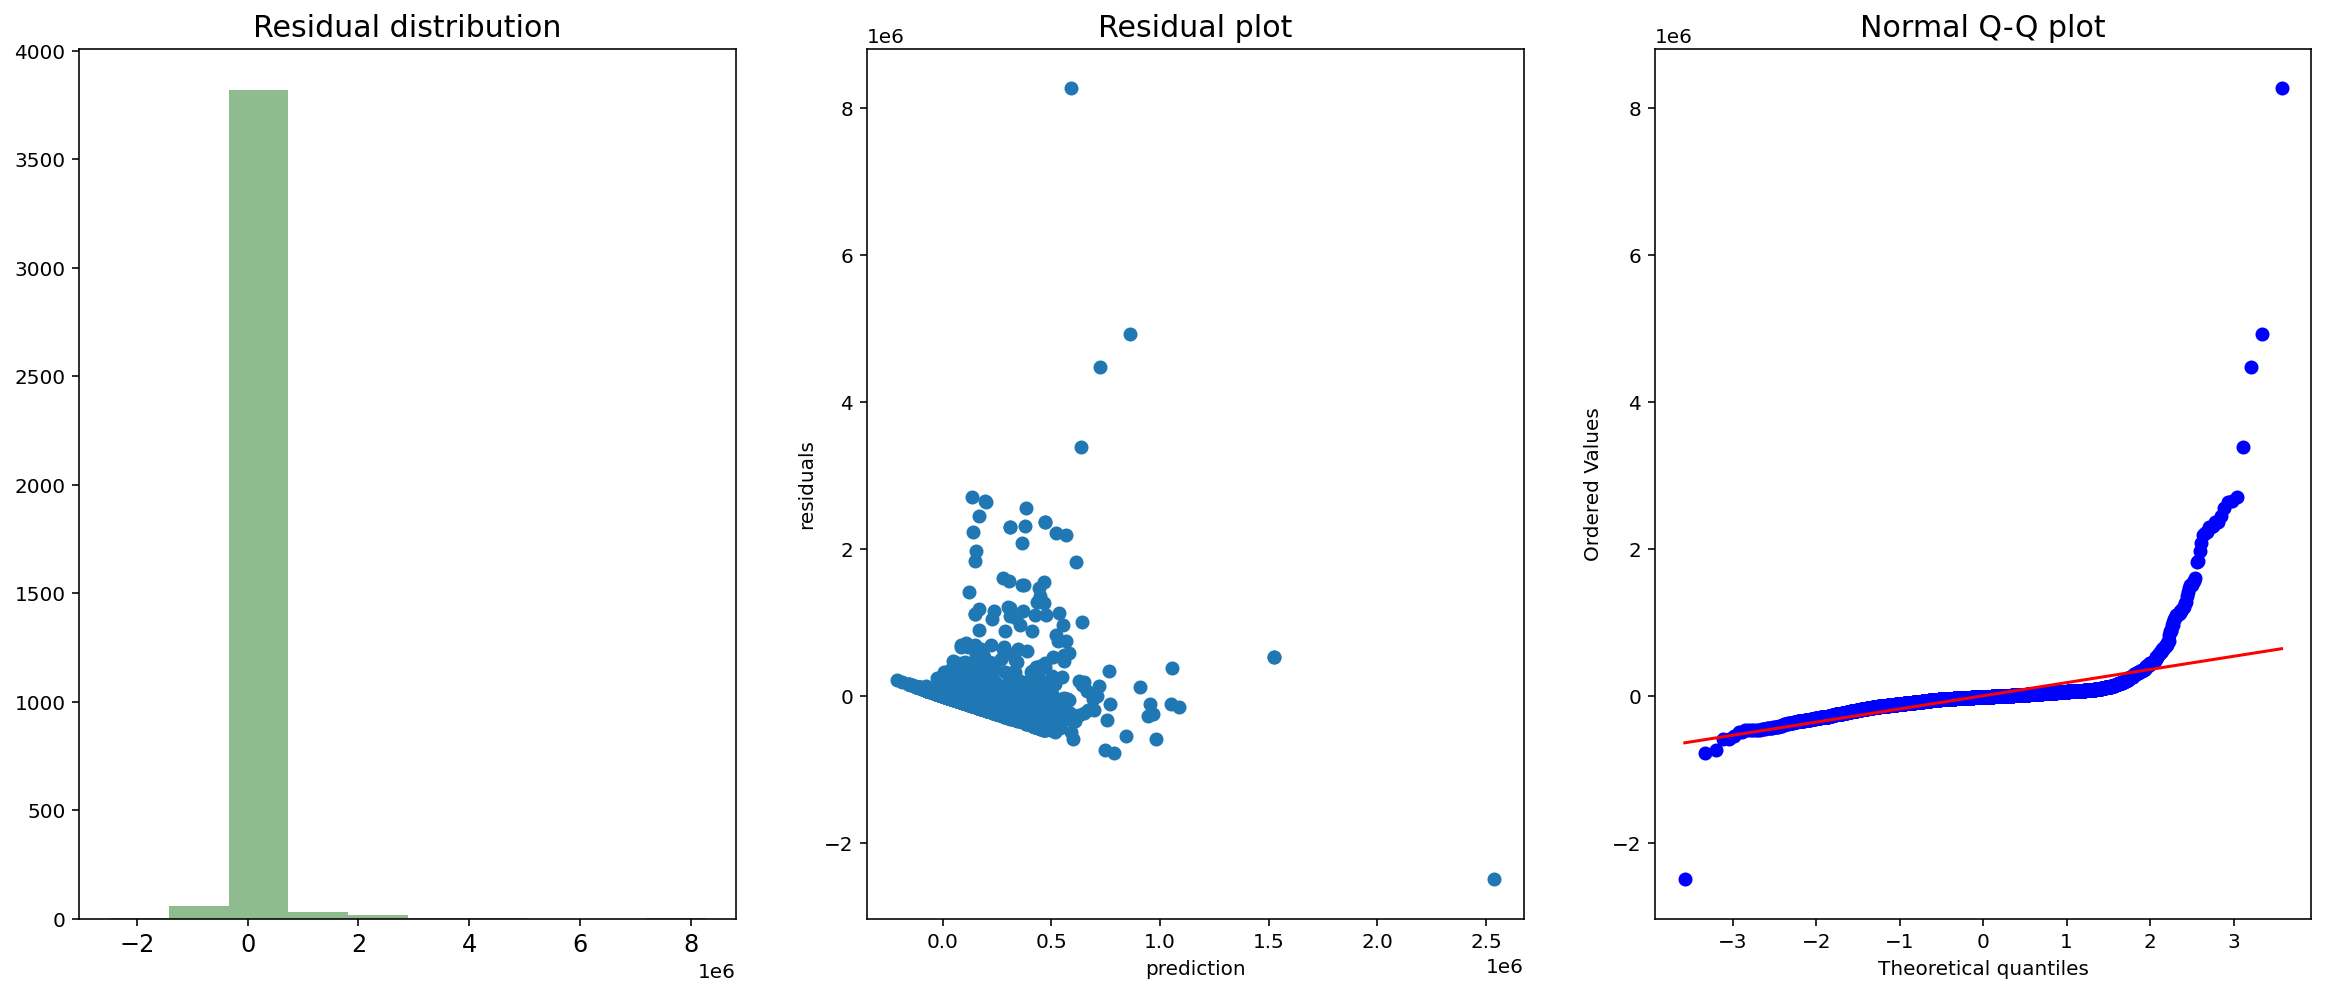

In [39]:
diagnostic_plot(X_train, y_train)

In [40]:
lasso_score(X_train, y_train)

-1.051904057068549

In [41]:
lasso_score(X_holdout, y_holdout)

-0.11395637945871023

In [42]:
ridge_score(X_train, y_train)

-0.9562494187460787

In [43]:
ridge_score(X_holdout, y_holdout)

-0.17993868683658434

In [44]:
polynomial_reg_score(X_train, y_train)

-3.3491511473443296

In [45]:
polynomial_reg_score(X_holdout, y_holdout)

-0.5180563443909277

In [46]:
linear_regression_score(X_train, y_train)

-1.0178857461486124

In [47]:
linear_regression_score(X_holdout, y_holdout)

-0.27908873757174196

### *Definitely not the right model*

### Try droppping columns with box-cox y

In [48]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_all_dropped, 
                                                          y_box_cox, 
                                                          test_size=0.1, 
                                                          random_state=42)

In [49]:
model = LinearRegression()

model.fit(X_train, y_train)
score = model.score(X_train, y_train)

print('R\u00b2 for box-cox model with dropped features = ', score)

R² for box-cox model with dropped features =  0.4814789546647912


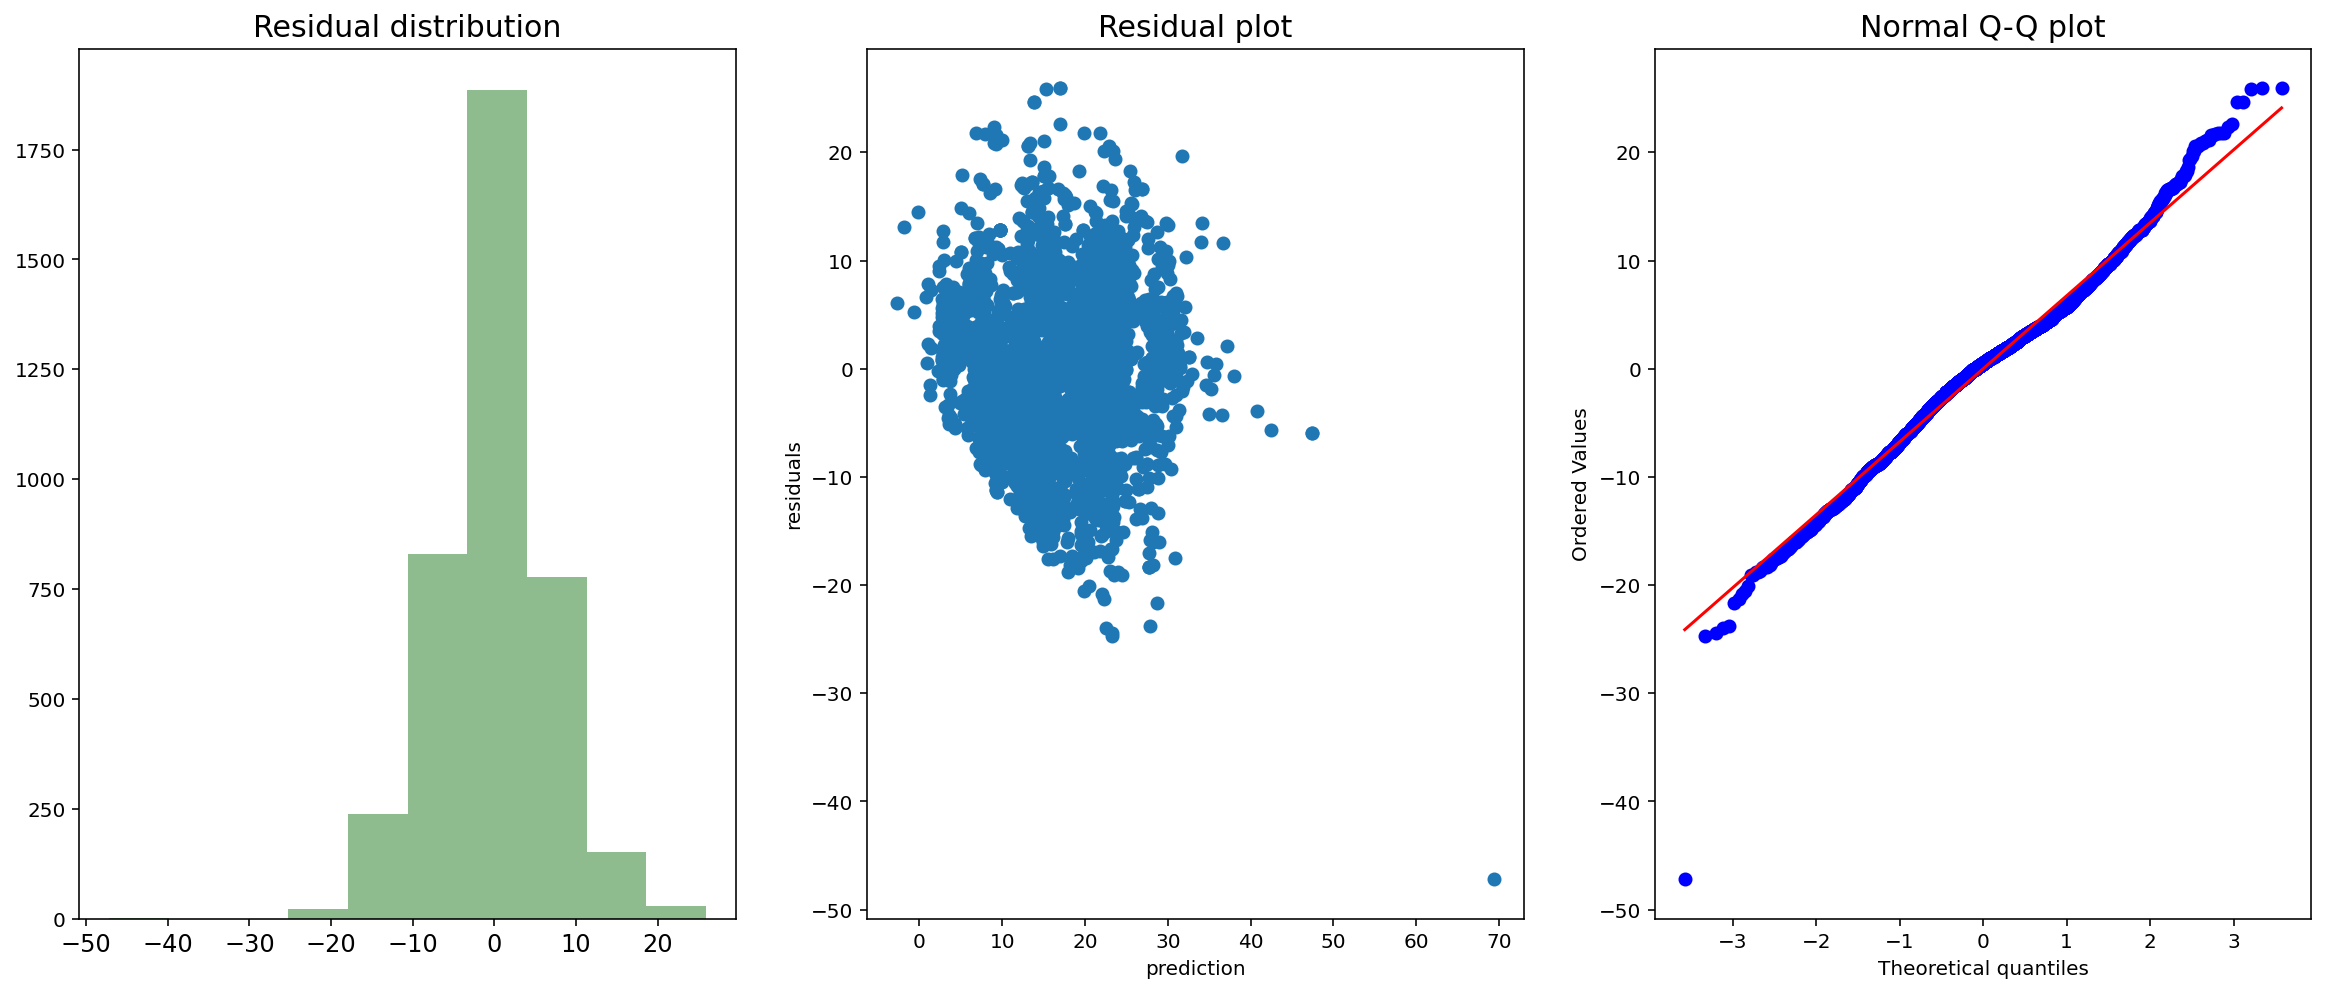

In [50]:
diagnostic_plot(X_train, y_train)

In [51]:
lasso_score(X_train, y_train)

0.04125818346018697

In [52]:
lasso_score(X_holdout, y_holdout)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.39853717119877, tolerance: 3.157820591267291
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.196183109750564, tolerance: 3.1253889745343706
  model = cd_fast.enet_coordinate_descent(


0.44610067736021347

In [53]:
ridge_score(X_train, y_train)

0.1512301121381486

In [54]:
ridge_score(X_holdout, y_holdout)

0.458390877661506

In [55]:
polynomial_reg_score(X_train, y_train)

-3.685869214941318

In [56]:
polynomial_reg_score(X_holdout, y_holdout)

-0.5503249123083878

In [57]:
linear_regression_score(X_train, y_train)

0.13441416669396403

In [58]:
linear_regression_score(X_holdout, y_holdout)

0.4424297570792636

### *Better, particularly the linear regression of the holdout*

### Try Log Transformation

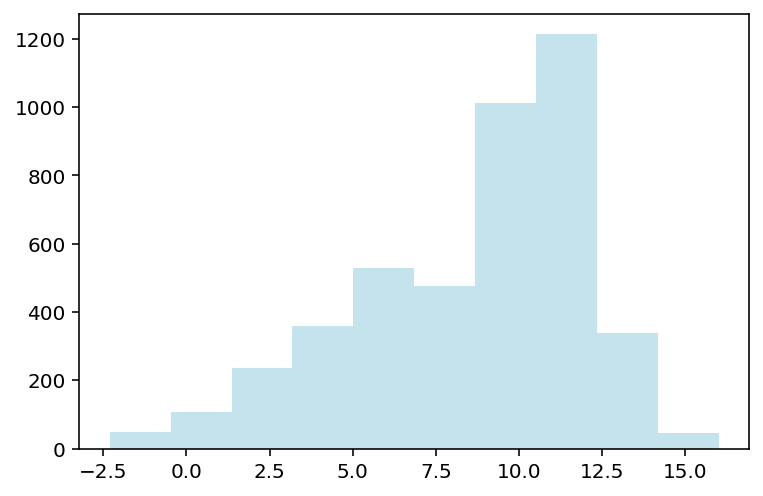

In [59]:
plt.hist(np.log(GHG_numeric.GHG_total), color = 'lightblue', alpha = 0.7);

In [60]:
GHG_w_log = GHG_df.copy()
GHG_w_log.head()

,PARENT COMPANY NAME,Unit Type,General Fuel Type,Industry,Number_of_units,GHG_total,Max_Heat_Cap,State%_Dem,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,30452.736,32.0,-21.32,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
1,3M CO,Combustion,Natural Gas,Other,1.0,106258.176,223.0,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
2,3M CO,Combustion,Petroleum Products,Other,1.0,106258.176,223.0,2.40,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0
3,3M CO,Combustion,Natural Gas,Metals/Minerals,1.0,29055.240,18.0,-14.92,2.013900e+10,8.350000e+08,2.580000e+08,2.012500e+10,1.078800e+10,26000.0
4,3M CO,Combustion,Natural Gas,Other,1.0,45435.226,60.0,0.22,6.465600e+10,3.204000e+09,3.103000e+09,5.947520e+10,2.537700e+10,90000.0


In [61]:
log_columns = ['GHG_total','Revenue', 'Operating_income','Net_income','Total_assets','Total_equity','Employees']
for column in log_columns:
    GHG_w_log['{}_log'.format(str(column))] = np.log(GHG_w_log[column])
GHG_w_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4367 entries, 0 to 4366
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PARENT COMPANY NAME   4367 non-null   object 
 1   Unit Type             4367 non-null   object 
 2   General Fuel Type     4367 non-null   object 
 3   Industry              4367 non-null   object 
 4   Number_of_units       4367 non-null   float64
 5   GHG_total             4367 non-null   float64
 6   Max_Heat_Cap          4367 non-null   float64
 7   State%_Dem            4367 non-null   float64
 8   Revenue               4367 non-null   float64
 9   Operating_income      4367 non-null   float64
 10  Net_income            4367 non-null   float64
 11  Total_assets          4367 non-null   float64
 12  Total_equity          4367 non-null   float64
 13  Employees             4367 non-null   float64
 14  GHG_total_log         4367 non-null   float64
 15  Revenue_log          

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Drop null values

In [62]:
GHG_w_log = GHG_w_log.dropna()
GHG_w_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3799 entries, 0 to 4366
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PARENT COMPANY NAME   3799 non-null   object 
 1   Unit Type             3799 non-null   object 
 2   General Fuel Type     3799 non-null   object 
 3   Industry              3799 non-null   object 
 4   Number_of_units       3799 non-null   float64
 5   GHG_total             3799 non-null   float64
 6   Max_Heat_Cap          3799 non-null   float64
 7   State%_Dem            3799 non-null   float64
 8   Revenue               3799 non-null   float64
 9   Operating_income      3799 non-null   float64
 10  Net_income            3799 non-null   float64
 11  Total_assets          3799 non-null   float64
 12  Total_equity          3799 non-null   float64
 13  Employees             3799 non-null   float64
 14  GHG_total_log         3799 non-null   float64
 15  Revenue_log          

In [63]:
y_for_log = GHG_w_log['GHG_total']
X_numeric = GHG_w_log[['Number_of_units', 'Max_Heat_Cap','State%_Dem',
                   'Revenue','Operating_income','Net_income','Total_assets','Total_equity','Employees']]

X_numeric_log = GHG_w_log[['Number_of_units', 'Max_Heat_Cap','State%_Dem',
                      'Revenue_log','Operating_income_log','Net_income_log','Total_assets_log',
                       'Total_equity_log','Employees_log']]

X_categorical = GHG_w_log[['Unit Type','General Fuel Type','Industry']]

In [64]:
X_dummies = pd.get_dummies(X_categorical)

In [65]:
X_all_for_log = X_numeric_log.join(X_dummies)
X_all_for_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3799 entries, 0 to 4366
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Number_of_units                             3799 non-null   float64
 1   Max_Heat_Cap                                3799 non-null   float64
 2   State%_Dem                                  3799 non-null   float64
 3   Revenue_log                                 3799 non-null   float64
 4   Operating_income_log                        3799 non-null   float64
 5   Net_income_log                              3799 non-null   float64
 6   Total_assets_log                            3799 non-null   float64
 7   Total_equity_log                            3799 non-null   float64
 8   Employees_log                               3799 non-null   float64
 9   Unit Type_Boiler                            3799 non-null   uint8  
 10  Unit Type_Co

In [66]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_all_for_log, 
                                                          y_for_log, 
                                                          test_size=0.1, 
                                                          random_state=42)

In [67]:
model = LinearRegression()

model.fit(X_train, y_train)
score = model.score(X_train, y_train)

print('R\u00b2 for baseline categorical model = ', score)

R² for baseline categorical model =  0.18931146671271915


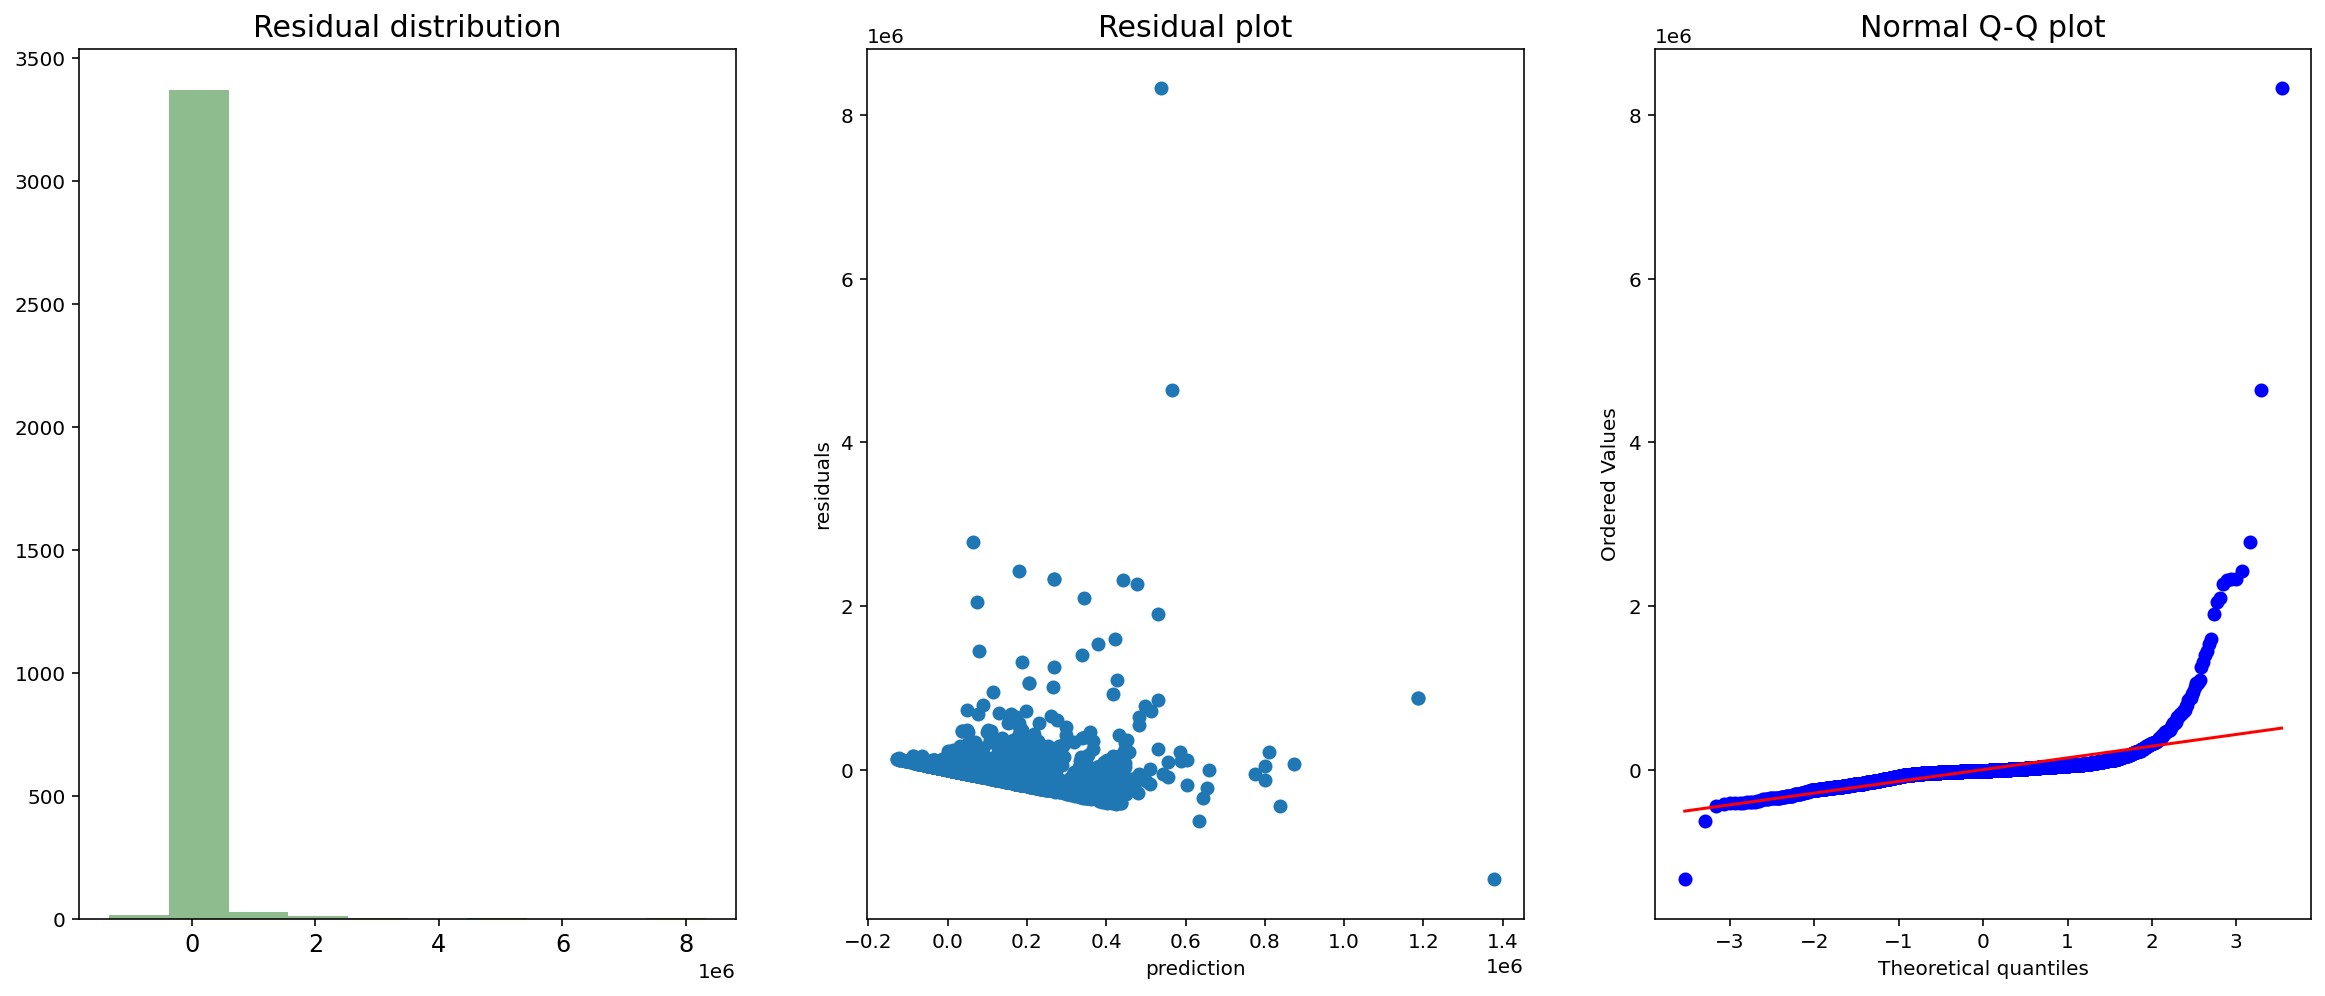

In [68]:
diagnostic_plot(X_train, y_train)

In [69]:
lasso_score(X_train, y_train)

-0.7480375904314761

In [70]:
lasso_score(X_holdout, y_holdout)

0.2538986219892822

In [71]:
ridge_score(X_train, y_train)

-0.6598485540298402

In [72]:
ridge_score(X_holdout, y_holdout)

0.1268990117159889

In [73]:
polynomial_reg_score(X_train, y_train)

-13.819513162584407

In [74]:
polynomial_reg_score(X_holdout, y_holdout)

-1.1852690193358568e+17

In [75]:
linear_regression_score(X_train, y_train)

-0.7297047146948489

In [76]:
linear_regression_score(X_holdout, y_holdout)

0.06732397665877629

### *Not great*

### Log of features and target

In [80]:
log_y = GHG_w_log['GHG_total_log']

In [81]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_all_for_log, 
                                                          log_y, 
                                                          test_size=0.1, 
                                                          random_state=42)

In [93]:
model = LinearRegression()

model.fit(X_train, y_train)
score = model.score(X_train, y_train)

print('R\u00b2 for baseline categorical model = ', score)

R² for baseline categorical model =  0.4570974981897721


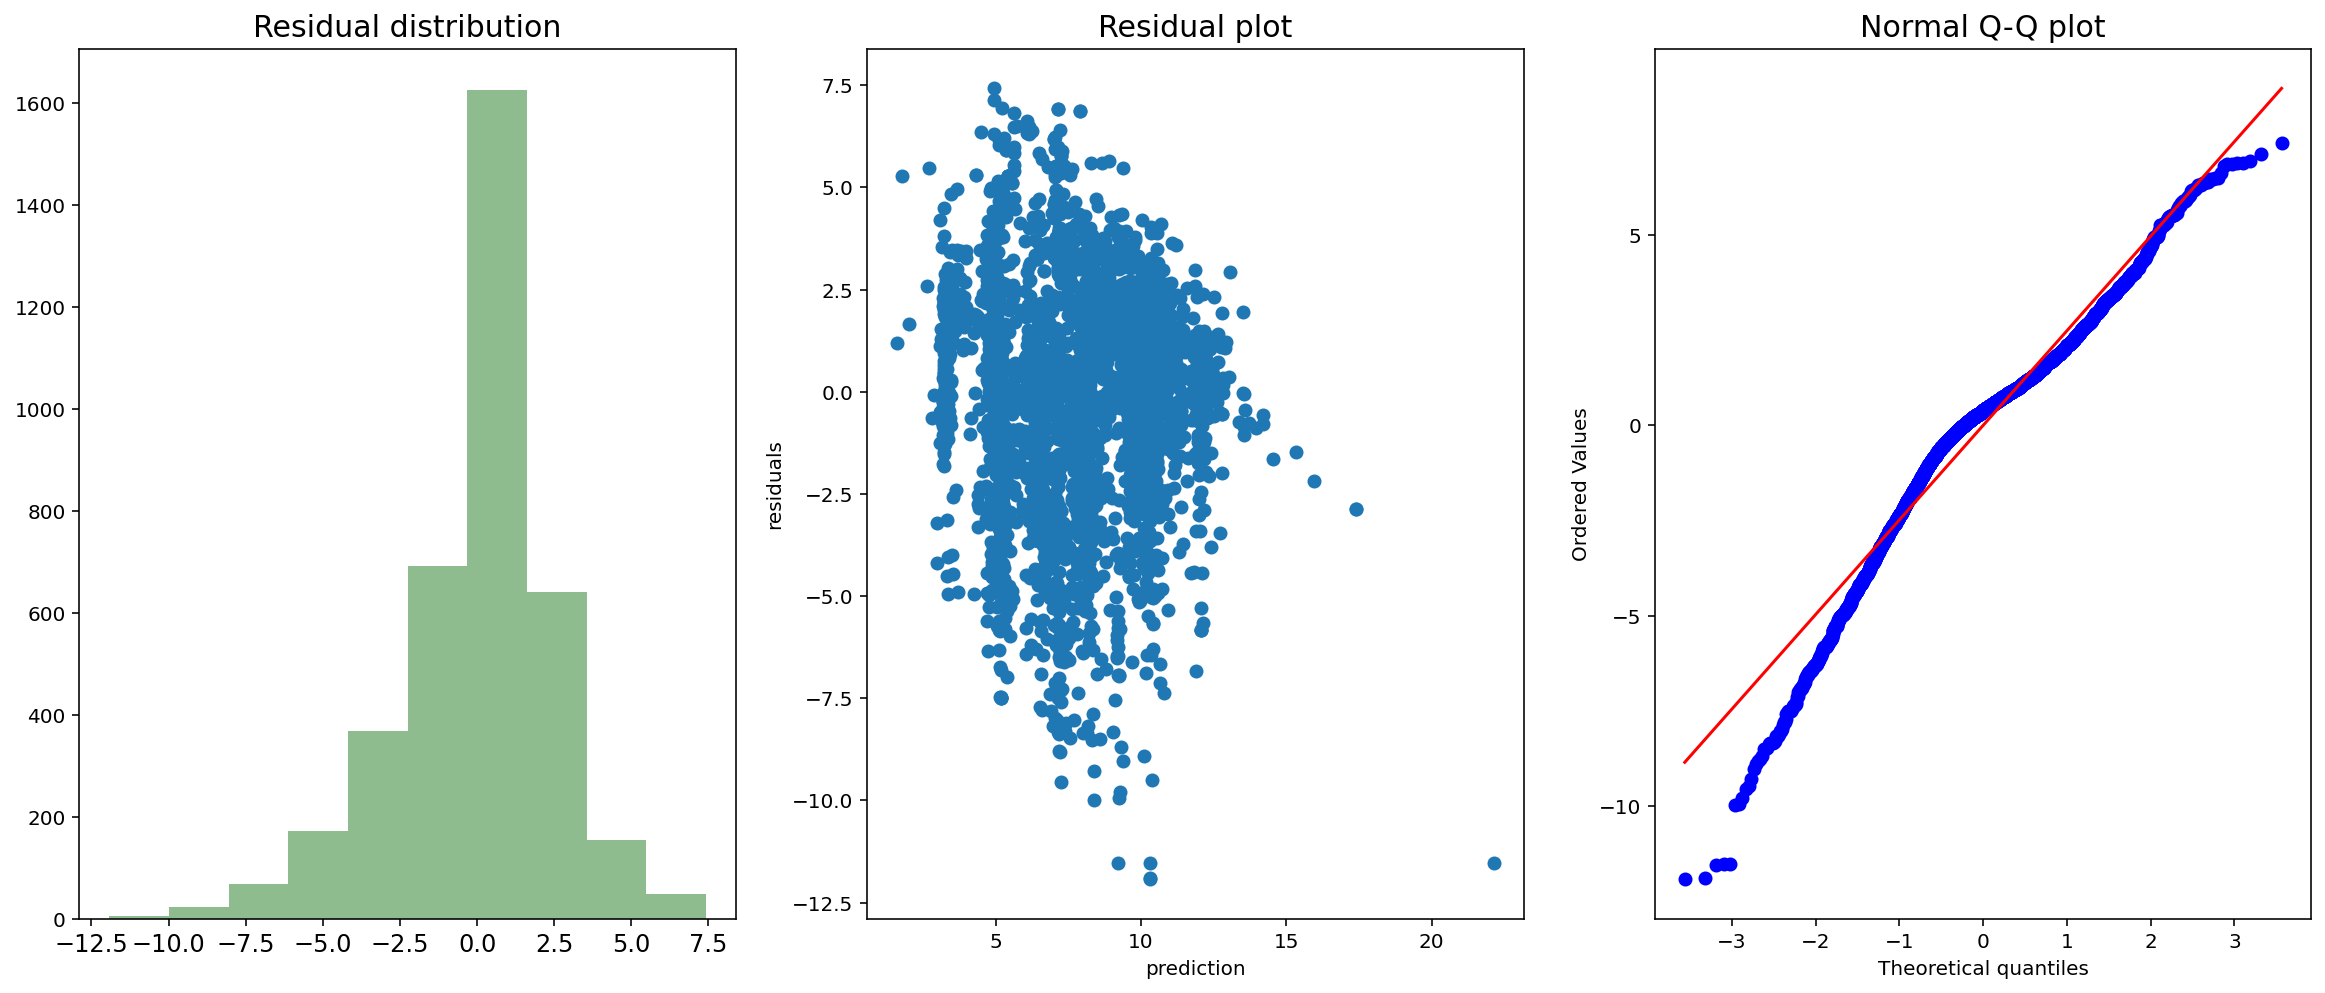

In [83]:
diagnostic_plot(X_train, y_train)

In [84]:
lasso_score(X_train, y_train)

0.20301744935452887

In [85]:
lasso_score(X_holdout, y_holdout)

0.44287439577245963

In [86]:
ridge_score(X_train, y_train)

0.2437038112671347

In [87]:
ridge_score(X_holdout, y_holdout)

0.422806374707622

In [88]:
polynomial_reg_score(X_train, y_train)

-62.742726939924914

In [89]:
polynomial_reg_score(X_holdout, y_holdout)

-9.640159672443892e+17

In [90]:
linear_regression_score(X_train, y_train)

0.22756902276529967

In [91]:
linear_regression_score(X_holdout, y_holdout)

0.4121893169934853

### Log on features with box-cox on y

Lambda: 0.12831417492147212


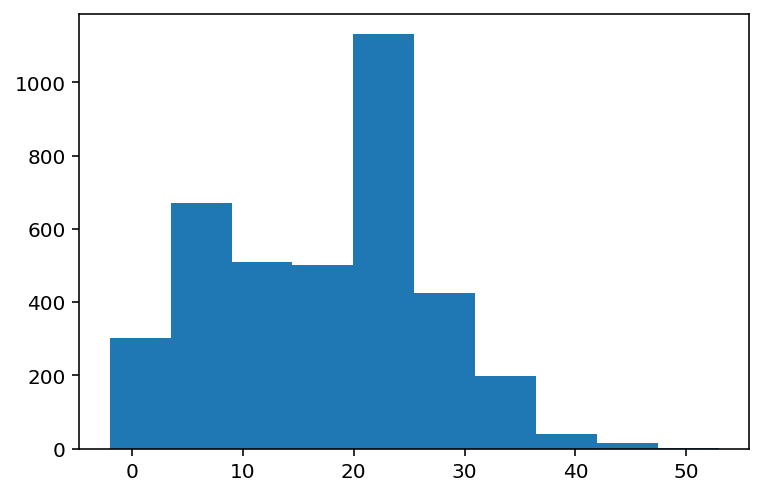

In [92]:
lamb=stats.boxcox_normmax(y_for_log, brack=(-3, 5)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_for_log_box_cox =(np.power(y_for_log,lamb)-1)/lamb #transform y based on box-cox

plt.hist(y_for_log_box_cox);

In [94]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_all_for_log, 
                                                          y_for_log_box_cox, 
                                                          test_size=0.1, 
                                                          random_state=42)

In [95]:
model = LinearRegression()

model.fit(X_train, y_train)
score = model.score(X_train, y_train)

print('R\u00b2 for baseline categorical model = ', score)

R² for baseline categorical model =  0.4788865520217145


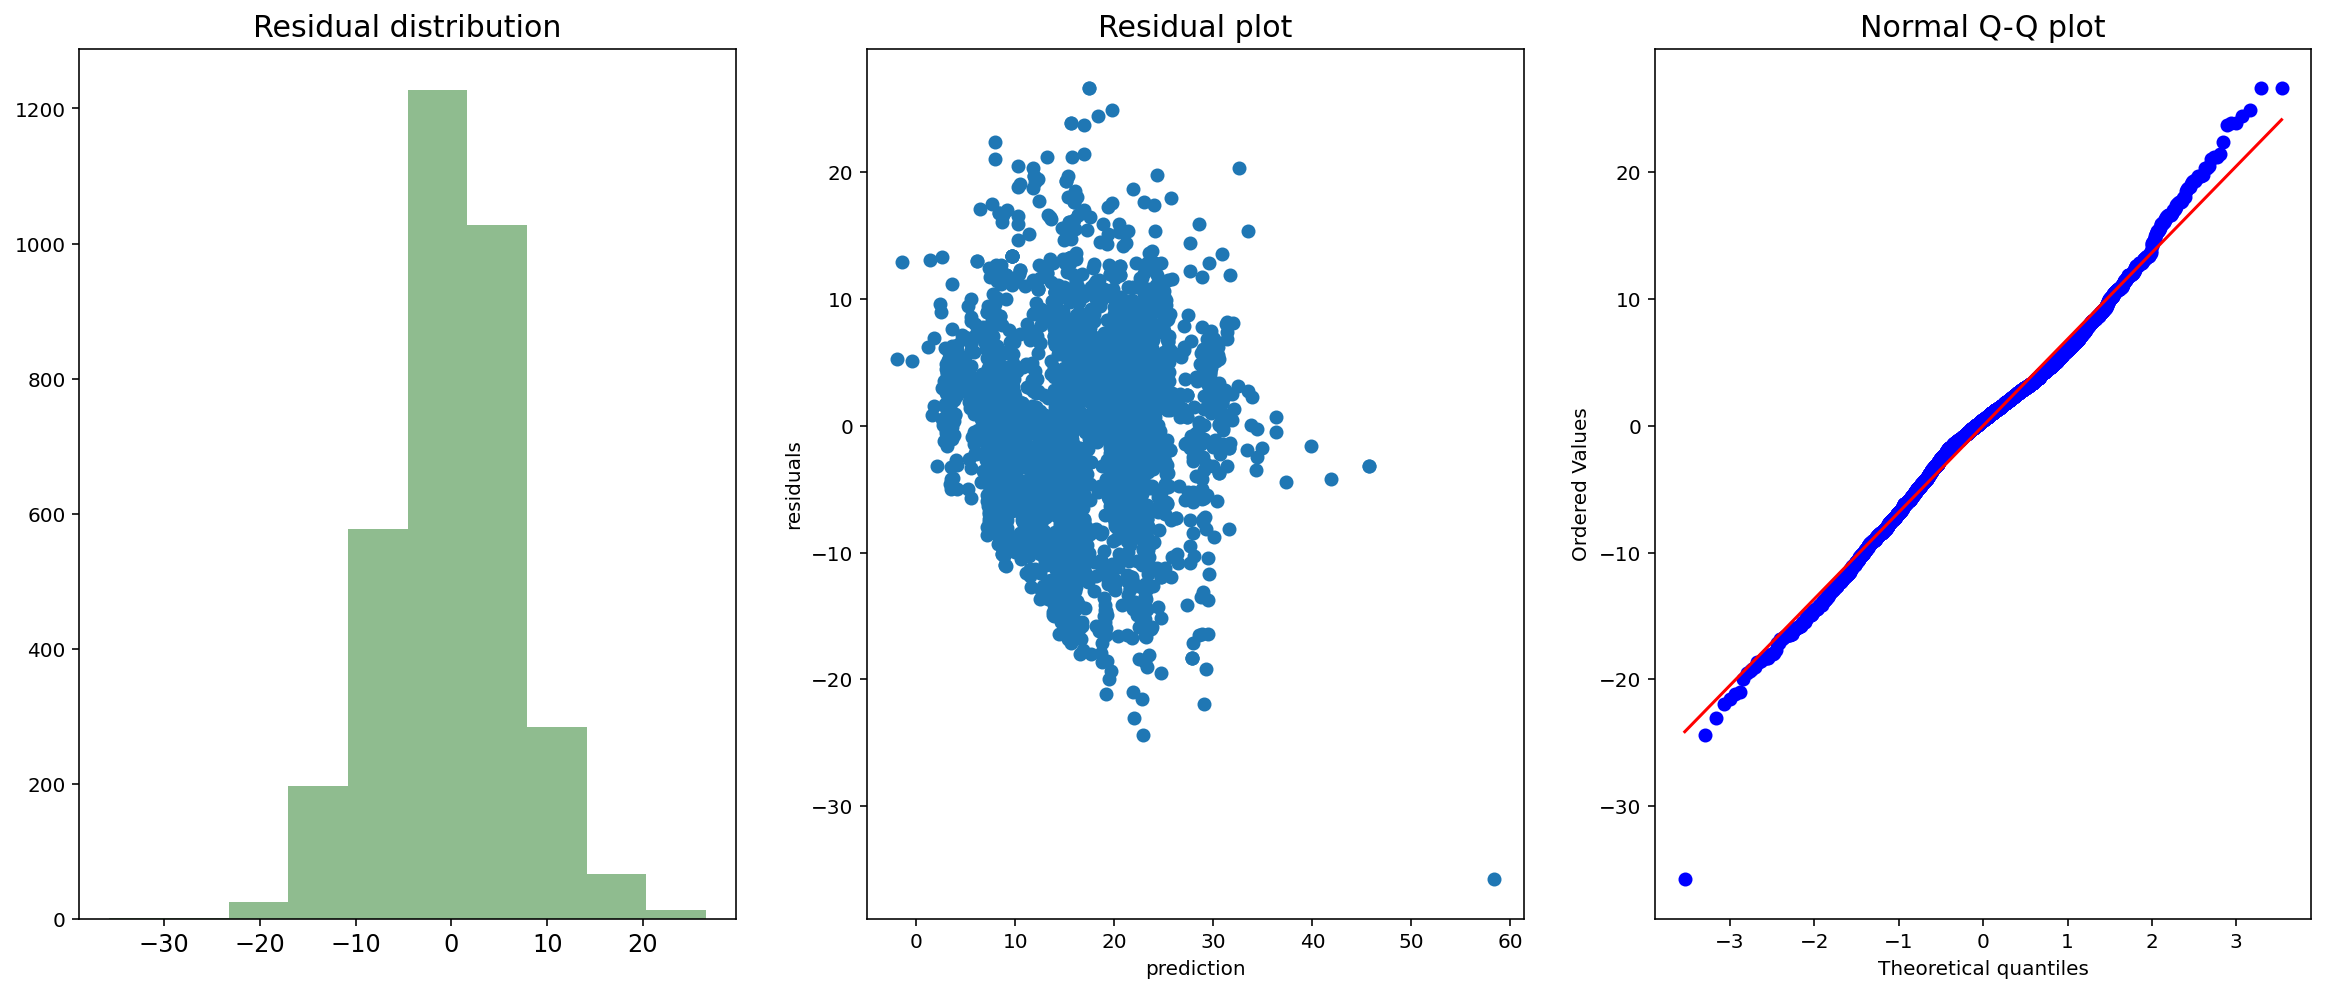

In [96]:
diagnostic_plot(X_train, y_train)

In [97]:
lasso_score(X_train, y_train)

0.042718708676237845

In [98]:
lasso_score(X_holdout, y_holdout)

0.5001180889642537

In [99]:
ridge_score(X_train, y_train)

0.1282530621742977

In [100]:
ridge_score(X_holdout, y_holdout)

0.4880069907964858

In [101]:
polynomial_reg_score(X_train, y_train)

-51.907930447787805

In [102]:
polynomial_reg_score(X_holdout, y_holdout)

-9.240409260049806e+17

In [103]:
linear_regression_score(X_train, y_train)

0.10115673057890193

In [104]:
linear_regression_score(X_holdout, y_holdout)

0.4775368140813908

### Best r_squared in lasso for log(features) and box-cox y

## FINAL MODEL

In [106]:
model = sm.OLS(y_box_cox, sm.add_constant(X_all_dropped))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              GHG_total   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     168.4
Date:                Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                        00:13:20   Log-Likelihood:                -14554.
No. Observations:                4367   AIC:                         2.916e+04
Df Residuals:                    4342   BIC:                         2.932e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         10.7089      0.324     33.066      0.000      10.074      11.344
Number_of_units                                0.4424      0.039     11.419      0.000       0.366       0.518
Max_Heat_Cap                                   0.0007   7.81e-05      8.467      0.000       0.001       0.001
State%_Dem                                    -0.0262      0.007     -3.519      0.000      -0.041      -0.012
Revenue                                     2.378e-11   3.66e-12      6.492      0.000    1.66e-11     3.1e-11
Total_assets                               -5.596e-12   1.66e-12     -3.379      0.001   -8.84e-12   -2.35e-12
Employees                                  -1.413e-05    3.6e-06     -3.923      0.000   -2.12e-05   -7.07e-06
Unit Type_Boiler                               4.6242      0.410     11.276      0.000       3.820       5.428
Unit Type_Combustion                           5.2661      0.343     15.346      0.000       4.593       5.939
Unit Type_Furnace                              2.7241      0.865      3.150      0.002       1.029       4.419
Unit Type_Heater                              -0.8916      0.419     -2.130      0.033      -1.712      -0.071
Unit Type_Heater adjacent                     -2.8607      0.987     -2.897      0.004      -4.796      -0.925
Unit Type_Natural Gas Line                    -4.4723      0.714     -6.259      0.000      -5.873      -3.072
Unit Type_Oxidizer                            -3.1858      0.827     -3.851      0.000      -4.808      -1.564
Unit Type_Pulverized Coal                      9.5049      1.639      5.799      0.000       6.292      12.718
General Fuel Type_Coal                         4.3321      1.204      3.599      0.000       1.972       6.692
General Fuel Type_Natural Gas                  2.8861      0.372      7.752      0.000       2.156       3.616
General Fuel Type_Other                        8.9404      0.454     19.673      0.000       8.049       9.831
General Fuel Type_Petroleum Products          -5.4496      0.394    -13.824      0.000      -6.222      -4.677
Industry_CO2                                   2.9031      0.885      3.279      0.001       1.167       4.639
Industry_Chemicals                             2.4281      0.470      5.168      0.000       1.507       3.349
Industry_Metals/Minerals                       3.5616      0.420      8.483      0.000       2.738       4.385
Industry_Other                                 2.0465      0.359      5.702      0.000       1.343       2.750
Industry_Petroleum and Natural Gas Systems     0.4157      0.271      1.533      0.125      -0.116       0.947
Industry_Power Plants                         -3.3977      0.349     -9.734      0.000